In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
from pylab import *
import random

In [165]:
data = pd.read_csv('text.txt', sep=",", header=None)
data.columns = ["x", "y","kind"]
MAX_DEPTH=5
BOUNDARY_NUM=1

<AxesSubplot:xlabel='x', ylabel='y'>

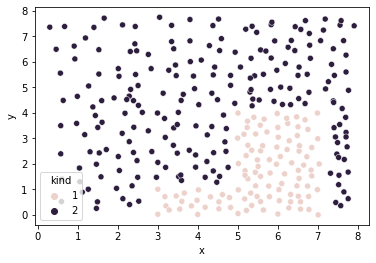

In [166]:
sns.scatterplot(data=data, x="x", y="y",hue="kind")

In [167]:
def entropy(data):
    if len(data) == 0:
        return 0
    p1=len(data[data['kind']==1])/len(data)
    p2=len(data[data['kind']==2])/len(data)
    return -1*(p1*(math.log(p1,2)) if p1 !=0 else 0) + -1*(p2*(math.log(p2,2)) if p2 !=0 else 0)

In [168]:
def information_gain(x_y,value,data):
    a1=data[data[x_y]>value]
    a2=data[data[x_y]<value]
    
    data_entropy = entropy(data)
    a1_entropy = entropy(a1)
    a2_entropy = entropy(a2)
    s1_d = len(a1)/len(data)
    s2_d = len(a2)/len(data)
    weighted_entropy = s1_d*a1_entropy+s2_d*a2_entropy
    return data_entropy -(weighted_entropy),a1_entropy,a2_entropy,weighted_entropy

In [169]:
x_s=data.sort_values("x").reset_index().drop(columns="index")['x'].reset_index().drop(columns="index")
x_s['x2'] = x_s.x.shift(1)
y_s=data.sort_values("y").reset_index().drop(columns="index")['y'].reset_index().drop(columns="index")
y_s['x2'] = y_s.y.shift(1)
x_s['mid']=x_s.mean(axis=1)
y_s['mid']=y_s.mean(axis=1)

In [170]:
def choose_best_cut(data):
    entropies=[]
    for count, axis in enumerate([x_s['mid'],y_s['mid']]):
        for num in axis:
            if count==0:
                entropies.append(("x",num,information_gain("x",num,data)))
            if count==1:
                entropies.append(("y",num,information_gain("y",num,data)))        
    return max(entropies, key = lambda t: t[2])
    #return entropies

In [171]:
def recursive(data,plots,depth):
    global BOUNDARY_NUM
    if depth==MAX_DEPTH:
        return "he"
    best=choose_best_cut(data)
    axis=best[0]
    boundary=best[1]
    info_gain=best[2][0]
    left_entropy=best[2][1]
    right_entropy=best[2][2]
    weighted_entropy=best[2][3]
    if info_gain < 0.01:
        return "he"
    print("boundary " + str(BOUNDARY_NUM))
    BOUNDARY_NUM = BOUNDARY_NUM+1
    print("left entropy: "+ str(left_entropy))
    print("right entropy: "+ str(right_entropy))
    print("weighted entropy: "+ str(weighted_entropy))

    if axis == "y":
        plots.append((data, "axhline", boundary, axis))
        area1=data[data["y"]<boundary]
        area2=data[data["y"]>boundary]
        recursive(area1,plots,depth+1)
        recursive(area2,plots,depth+1)
    if axis == "x":
        plots.append((data, "axvline", boundary, axis))
        area1=data[data["x"]<boundary]
        area2=data[data["x"]>boundary]
        recursive(area1,plots,depth+1)
        recursive(area2,plots,depth+1)

# Step by Step figures

In [172]:
plots=[]
recursive(data,plots,0)

boundary 1
left entropy: 0.0
right entropy: 0.9945386816500111
weighted entropy: 0.5865228122551348
boundary 2
left entropy: 0.9037762882345832
right entropy: 0.0
weighted entropy: 0.7073031820966303
boundary 3
left entropy: 0.0
right entropy: 0.7527960664084546
weighted entropy: 0.6534688076462281
boundary 4
left entropy: 0.0
right entropy: 0.9522656254366642
weighted entropy: 0.32757937515021246
boundary 5
left entropy: 0.0
right entropy: 0.0
weighted entropy: 0.0


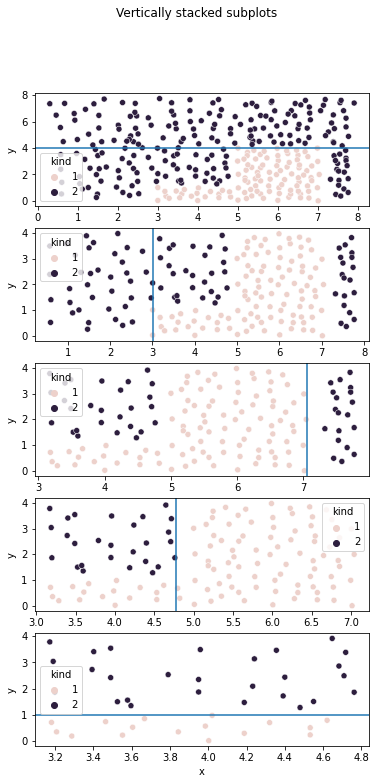

In [173]:
fig, axs = plt.subplots(len(plots),1, figsize=(6, 12), sharex=False)
fig.suptitle('Vertically stacked subplots')

for i, plot in enumerate(plots):
    if plot[1]=="axhline":
        sns.scatterplot(data=plot[0],x="x", y="y",hue="kind",ax=axs[i]).axhline(plot[2])
    else:
        sns.scatterplot(data=plot[0],x="x", y="y",hue="kind",ax=axs[i]).axvline(plot[2])

plt.show()

# Final Layout on the Splitted Data

In [174]:
lines=[]
for count, plot in enumerate(plots):
    move = plot[0] 
    where=plot[2]    
    axis = plot[3]
    if axis == "y":
        max_=max(move["x"])
        min_=min(move["x"])
    else:
        max_=max(move["y"])
        min_=min(move["y"]) 
    lines.append((where,max_,min_,axis))
lines = pd.DataFrame(lines, columns=['where', 'max', 'min','axis'])    

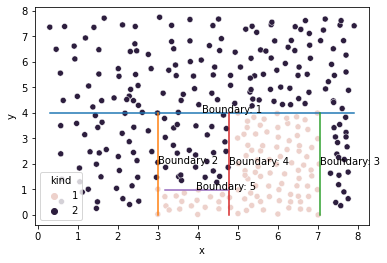

In [175]:
sns.scatterplot(data=data, x="x", y="y",hue="kind")
for i in range(len(lines)):
    line = lines.iloc[i]
    if line['axis']=='y':
        plt.plot([line['min'],line['max']],[line['where'],line['where']])
        plt.text((line['min']+line['max'])/2,line['where'],"Boundary: " + str(i+1))
    elif line['axis']=='x':
        plt.plot([line['where'],line['where']],[line['min'],line['max']])  
        plt.text(line['where'],(line['min']+line['max'])/2,"Boundary: " + str(i+1))

In [176]:
lines

,where,max,min,axis
0,3.993816,7.916078,0.301237,y
1,3.004417,3.984982,0.000883,x
2,7.059187,3.976148,0.000883,x
3,4.780035,3.976148,0.000883,x
4,0.981449,4.762367,3.172261,y


# Scikit Learn

In [177]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import tree
from sklearn.tree import export_text

[Text(223.20000000000002, 199.32, 'X[1] <= 4.007\nentropy = 0.912\nsamples = 312\nvalue = [102, 210]'),
 Text(167.4, 163.07999999999998, 'X[0] <= 3.0\nentropy = 0.994\nsamples = 187\nvalue = [102, 85]'),
 Text(111.60000000000001, 126.83999999999999, 'entropy = 0.0\nsamples = 38\nvalue = [0, 38]'),
 Text(223.20000000000002, 126.83999999999999, 'X[0] <= 7.183\nentropy = 0.899\nsamples = 149\nvalue = [102, 47]'),
 Text(167.4, 90.6, 'X[0] <= 4.78\nentropy = 0.752\nsamples = 130\nvalue = [102, 28]'),
 Text(111.60000000000001, 54.359999999999985, 'X[1] <= 1.145\nentropy = 0.966\nsamples = 46\nvalue = [18, 28]'),
 Text(55.800000000000004, 18.119999999999976, 'entropy = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(167.4, 18.119999999999976, 'entropy = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(223.20000000000002, 54.359999999999985, 'entropy = 0.0\nsamples = 84\nvalue = [84, 0]'),
 Text(279.0, 90.6, 'entropy = 0.0\nsamples = 19\nvalue = [0, 19]'),
 Text(279.0, 163.07999999999998, 'entropy = 0.

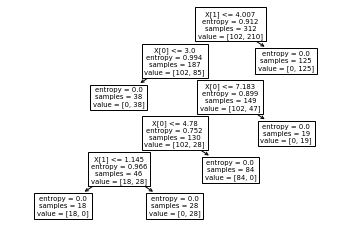

In [179]:
y= data['kind']
X=data.drop(columns="kind")

clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = clf.fit(X,y)
tree.plot_tree(clf)